In [ ]:
from pathlib import Path
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

DB_PATH  = Path("retail-analytics/retail.db")
SQL02    = Path("retail-analytics/sql/02_model_star.sql")
SQL03    = Path("retail-analytics/sql/03_analysis.sql")

print("CWD:", Path.cwd())
print("DB exists?", DB_PATH.exists(), "size:", DB_PATH.stat().st_size if DB_PATH.exists() else "NA")

# Plot style
sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

CWD: /Users/faezehhosseini/projects/retail-analytics/notebooks
DB exists? True size: 175509504


In [ ]:
with sqlite3.connect(DB_PATH) as con:
    # create star schema
    con.executescript(SQL02.read_text())
    con.executescript(SQL03.read_text())

    objs = pd.read_sql_query(
        "SELECT name, type FROM sqlite_master WHERE type IN ('table','view') ORDER BY type, name;",
        con
    )
    display(objs)

    # Sanity checks
    display(pd.read_sql_query("SELECT COUNT(*) AS n_rows FROM fact_invoice_line", con))
    display(pd.read_sql_query("SELECT * FROM v_monthly_revenue LIMIT 3", con))

,name,type
0,dim_customer,table
1,dim_date,table
2,dim_product,table
3,fact_invoice_line,table
4,stg_invoice,table
5,stg_invoice_raw,table
6,v_cohort_pairs,view
7,v_cohort_retention,view
8,v_cohort_sizes,view
9,v_country_revenue,view


,n_rows
0,525461


,year_month,revenue
0,2009-12,799847.11
1,2010-01,624032.89
2,2010-02,533091.43


In [14]:
Path("figures").mkdir(exist_ok=True)

def q(sql: str) -> pd.DataFrame:
    with sqlite3.connect(DB_PATH) as con:
        return pd.read_sql_query(sql, con)

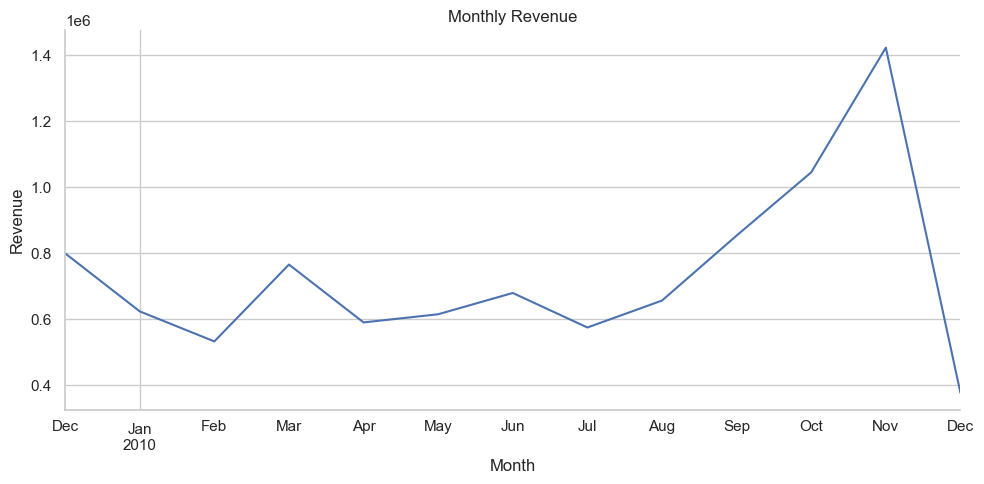

In [15]:
monthly = q("""
    SELECT year_month, revenue
    FROM v_monthly_revenue
    ORDER BY year_month
""")
monthly["year_month"] = pd.to_datetime(monthly["year_month"], format="%Y-%m")

ax = monthly.plot(x="year_month", y="revenue", legend=False)
ax.set_title("Monthly Revenue")
ax.set_xlabel("Month")
ax.set_ylabel("Revenue")
plt.tight_layout()
plt.savefig("figures/monthly_revenue.png", dpi=220)
plt.show()

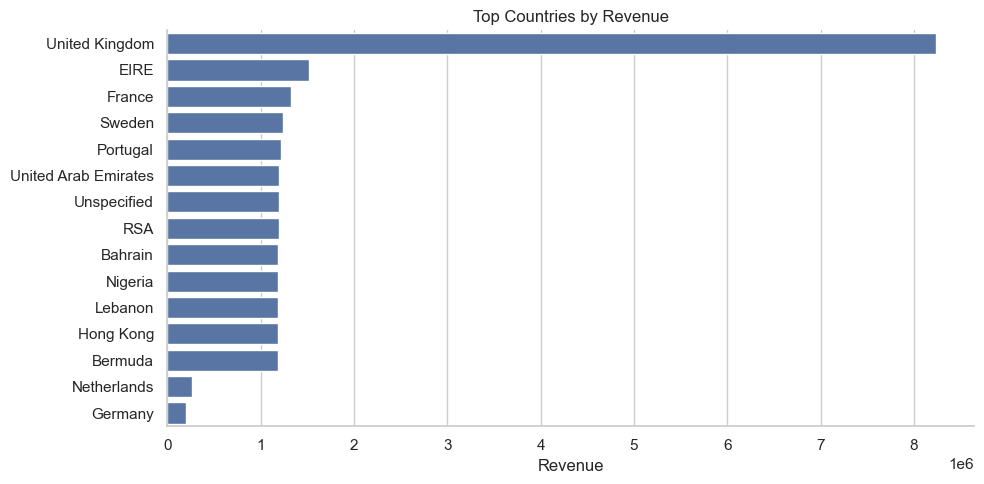

In [16]:
countries = q("""
    SELECT country, revenue
    FROM v_country_revenue
    ORDER BY revenue DESC
    LIMIT 15
""")

ax = sns.barplot(data=countries, x="revenue", y="country")
ax.set_title("Top Countries by Revenue")
ax.set_xlabel("Revenue")
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("figures/top_countries.png", dpi=220)
plt.show()


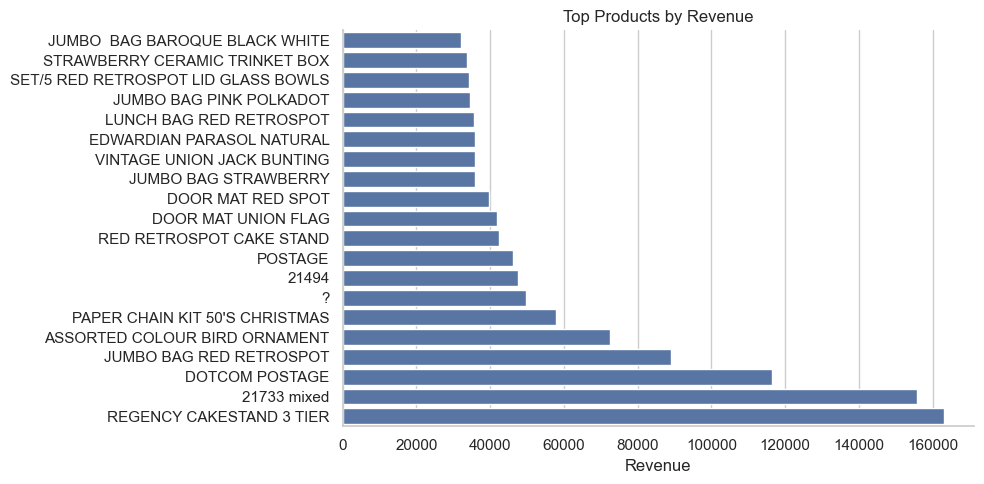

In [17]:
products = q("""
    SELECT product_name, revenue
    FROM v_top_products
    ORDER BY revenue DESC
    LIMIT 20
""")

ax = sns.barplot(
    data=products.sort_values("revenue", ascending=True),
    x="revenue", y="product_name"
)
ax.set_title("Top Products by Revenue")
ax.set_xlabel("Revenue")
ax.set_ylabel("")
plt.tight_layout()
plt.savefig("figures/top_products.png", dpi=220)
plt.show()

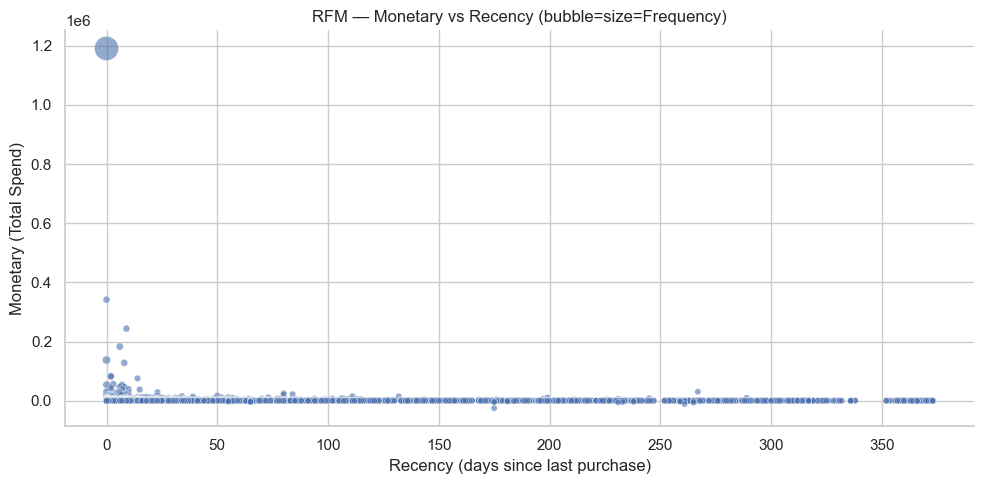

In [ ]:
rfm = q("SELECT * FROM v_rfm")

# rfm["monetary"] = rfm["monetary"].clip(upper=rfm["monetary"].quantile(0.99))

ax = sns.scatterplot(
    data=rfm, x="recency_days", y="monetary",
    size="frequency", sizes=(20, 300), alpha=0.6, legend=False
)
ax.set_title("RFM — Monetary vs Recency (bubble=size=Frequency)")
ax.set_xlabel("Recency (days since last purchase)")
ax.set_ylabel("Monetary (Total Spend)")
plt.tight_layout()
plt.savefig("figures/rfm_scatter.png", dpi=220)
plt.show()


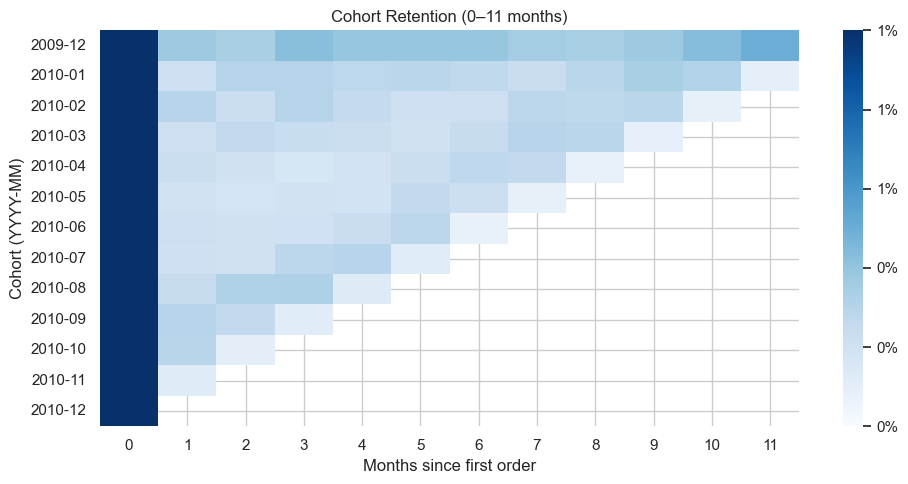

In [19]:
ret = q("""
    SELECT cohort, period, retention
    FROM v_cohort_retention
    WHERE period BETWEEN 0 AND 11
""")

pivot = ret.pivot(index="cohort", columns="period", values="retention").sort_index()

ax = sns.heatmap(
    pivot, cmap="Blues", vmin=0, vmax=1, annot=False, cbar_kws={"format": "%.0f%%"}
)
ax.set_title("Cohort Retention (0–11 months)")
ax.set_xlabel("Months since first order")
ax.set_ylabel("Cohort (YYYY-MM)")
plt.tight_layout()
plt.savefig("figures/cohort_retention.png", dpi=220)
plt.show()